### Layers

In [8]:
import numpy as np
# Dense layer
class Layer_Dense:
    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from input ones, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


### ReLU Activation

In [9]:
# ReLU activation
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify the original variable,
        # let’s make a copy of values first
        self.dinputs = dvalues.copy()
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0


### Softmax activation

In [10]:
# Softmax activation
class Activation_Softmax:
 # Forward pass
 def forward(self, inputs):
 # Get unnormalized probabilities
  exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
 # Normalize them for each sample
  probabilities = exp_values / np.sum(exp_values, axis=1,keepdims=True)
  self.output = probabilities

In [11]:
### Loss Class
# Common loss class
class Loss:
 # Calculates the data and regularization losses
 # given model output and ground truth values
 def calculate(self, output, y):
  # Calculate sample losses
  sample_losses = self.forward(output, y)
  # Calculate mean loss
  data_loss = np.mean(sample_losses)
  # Return loss
  return data_loss

### Cross Entropy Loss

In [12]:
class Loss_CategoricalCrossentropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples

### Combined softmax and cross entropy loss

In [13]:
# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy:
    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

### Dataset

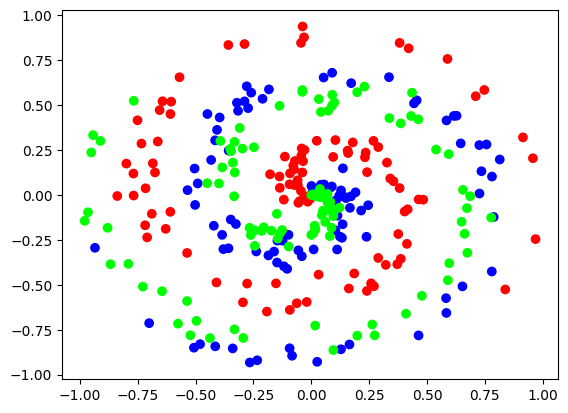

In [14]:
from nnfs.datasets import spiral_data
import numpy as np
import nnfs
nnfs.init()
import matplotlib.pyplot as plt
X, y = spiral_data(samples=100, classes=3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg')
plt.show()

In [15]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)
# Create Dense layer with 2 input features and 3 output values
dense1 = Layer_Dense(2, 3)
# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()
# Create second Dense layer with 3 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(3, 3)
# Create Softmax classifier’s combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
# Perform a forward pass of our training data through this layer
dense1.forward(X)
# Perform a forward pass through activation function
# takes the output of first dense layer here
activation1.forward(dense1.output)
# Perform a forward pass through second Dense layer
# takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)
# Perform a forward pass through the activation/loss function
# takes the output of second dense layer here and returns loss
loss = loss_activation.forward(dense2.output, y)

# Let’s see output of the first few samples:
print(loss_activation.output[:5])
# Print loss value
print('loss:', loss)
# Calculate accuracy from output of activation2 and targets
# calculate values along first axis
predictions = np.argmax(loss_activation.output, axis=1)
if len(y.shape) == 2:
 y = np.argmax(y, axis=1)
accuracy = np.mean(predictions == y)
# Print accuracy
print('acc:', accuracy)
# Backward pass
loss_activation.backward(loss_activation.output, y)
dense2.backward(loss_activation.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)
# Print gradients
print(dense1.dweights)
print(dense1.dbiases)
print(dense2.dweights)
print(dense2.dbiases)

[[0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.3333333  0.33333334]
 [0.3333335  0.333333   0.33333352]
 [0.33333334 0.33333334 0.33333334]]
loss: 1.0986118
acc: 0.33666666666666667
[[ 7.7209341e-05 -1.0590541e-04 -8.3512561e-05]
 [ 2.8525142e-04  6.1521474e-05 -9.9994701e-05]]
[[ 0.00036935 -0.00025332  0.00021116]]
[[ 1.0425548e-04  1.5916037e-05 -1.2017150e-04]
 [-4.9149978e-05  1.9419583e-04 -1.4504585e-04]
 [ 3.6147623e-05  1.0825427e-04 -1.4440189e-04]]
[[ 1.0384247e-05 -1.0518939e-05  3.9814040e-08]]
